In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.preprocessing import StandardScaler

# 일별 국채 CDS 가격 (2001~2025)
cds_df = pd.read_csv('../dataset/KOREA CDS 2001-2025.csv')
cds_df['date'] = pd.to_datetime(cds_df['date'].astype(str).str.replace(' ', ''))
cds_df = cds_df.sort_values('date')
cds_prep = cds_df.copy()
cds_prep['date'] = pd.to_datetime(cds_prep['date'])
cds_prep = cds_prep[['date', 'parspread']] # 필요한 컬럼만 선택
cds_prep['short'] = cds_prep['parspread'].rolling(5, min_periods=1).mean() # 5일 CDS 평균치
cds_prep['long']  = cds_prep['parspread'].rolling(252, min_periods=60).mean() # 252일 CDS 평균치
cds_prep['cds_gap'] = cds_prep['short'] - cds_prep['long'] # 5일평균 - 252일평균 (최근 변화량)
cds_prep = cds_prep.dropna()

# 검색량 데이터
df_trend_sum = pd.read_csv("../dataset/trend_sum.csv")
df_trend_sum['date'] = pd.to_datetime(df_trend_sum['date'])
# Risk Reversal 25 (2014~2025)
df_rr = pd.read_excel('./data/3M.xlsx') 
df_rr = df_rr.iloc[:, :2]
df_rr.columns = ['date', 'RR']

# 환율 데이터 (2014~2025)
df_exchange = yf.download('KRW=X', start='2014-01-01', end='2025-12-31')

# yfinance MultiIndex
if isinstance(df_exchange.columns, pd.MultiIndex):
    df_exchange.columns = df_exchange.columns.get_level_values(0)

df_exchange = df_exchange.reset_index()
if 'Date' in df_exchange.columns:
    df_exchange = df_exchange.rename(columns={'Date': 'date'})
df_exchange['date'] = pd.to_datetime(df_exchange['date']).dt.tz_localize(None)
df_exchange = df_exchange[['date', 'Close']].rename(columns={'Close': 'exchange_rate'})

# 데이터 병합
merged_df = cds_prep.copy()
merged_df = pd.merge(merged_df, df_trend_sum, on='date', how='inner') 
merged_df = pd.merge(merged_df, df_exchange, on='date', how='inner')
merged_df = pd.merge(merged_df,df_rr[['date','RR']],on='date',how='inner')
# 날짜순 정렬 및 인덱스 설정
merged_df = merged_df.sort_values('date').set_index('date')


# 3. 정규화 (0~1 Scaling) 함수 정의
def min_max_normalize(series):
    return (series - series.min()) / (series.max() - series.min())

# 각 지표 정규화 적용 
merged_df['cds_norm'] = min_max_normalize(merged_df['cds_gap'])
merged_df['RR_norm'] = min_max_normalize(merged_df['RR'])
merged_df['trend_sum_rank'] = merged_df['trend_sum'].rank(pct=True)
merged_df.head()

[*********************100%***********************]  1 of 1 completed


,parspread,short,long,cds_gap,trend_sum,minmax_trend_sum,rank_trend_sum,exchange_rate,RR,cds_norm,RR_norm,trend_sum_rank
date,,,,,,,,,,,,
2016-01-01,0.004848,0.004859,0.005083,-0.000224,4.159759,0.018238,0.039411,1174.109985,0.8,0.329707,0.349794,0.000385
2016-01-04,0.005020,0.004886,0.005079,-0.000193,13.348222,0.108707,0.535657,1174.109985,1.087,0.335864,0.397037,0.088145
2016-01-05,0.004969,0.004904,0.005074,-0.000171,13.897416,0.114429,0.584047,1187.359985,0.65,0.340270,0.325103,0.103926
2016-01-06,0.005193,0.004976,0.005070,-0.000095,14.946825,0.124695,0.645515,1188.719971,0.788,0.355429,0.347819,0.131640
2016-01-07,0.005516,0.005109,0.005068,0.000042,17.191959,0.146988,0.746363,1198.739990,0.875,0.382603,0.36214,0.186682


[corr] corr(fear_simple, exchange_rate) = 0.273317 (N=2598)


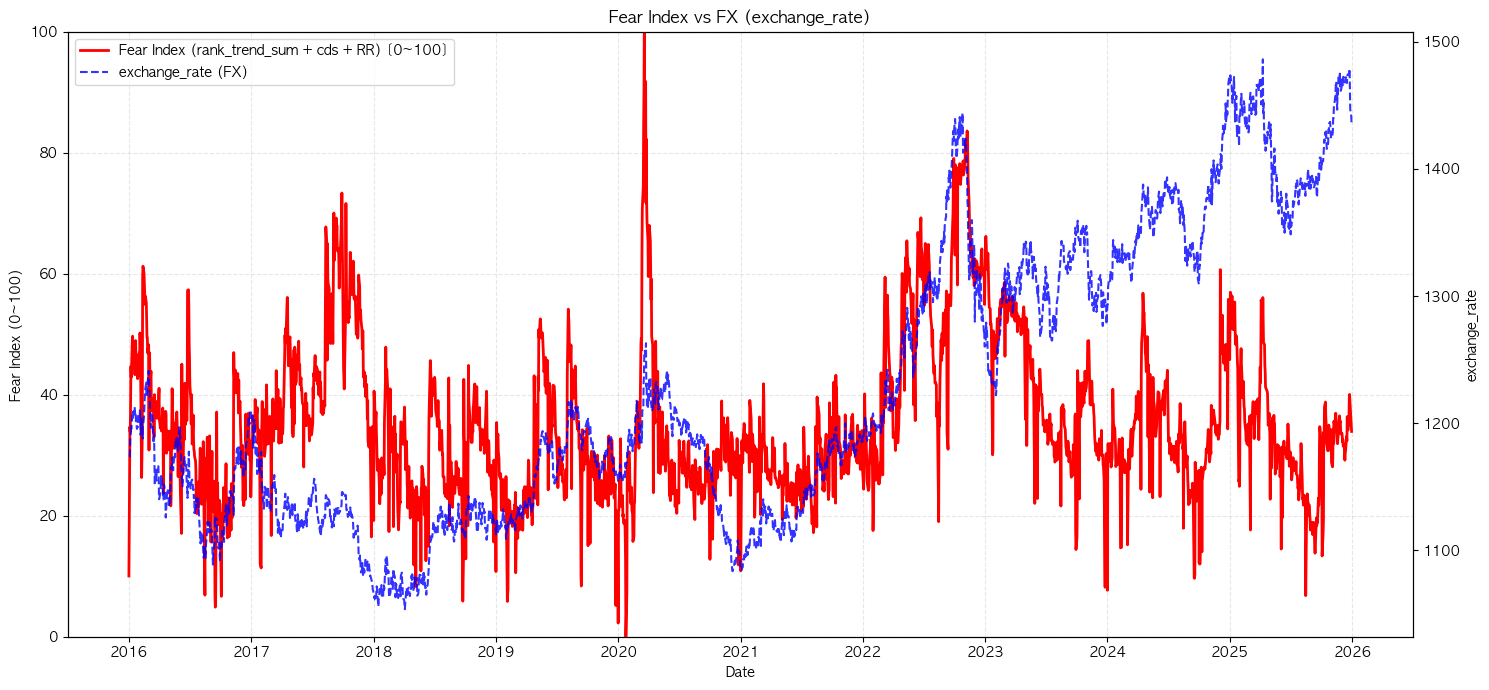

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = merged_df.copy()

FACTORS = ["rank_trend_sum", "cds_norm", "RR_norm"]

if "exchange_rate" in df.columns:
    FX_COL = "exchange_rate"
elif "real_rate" in df.columns:
    FX_COL = "real_rate"
else:
    raise ValueError

if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").set_index("date")
else:
    df = df.sort_index()
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

need = [FX_COL] + FACTORS
miss = [c for c in need if c not in df.columns]
if miss:
    raise ValueError(f"없는 컬럼: {miss}")

tmp = df[need].dropna().copy()

tmp["fear_simple"] = tmp[FACTORS].sum(axis=1)

mn, mx = tmp["fear_simple"].min(), tmp["fear_simple"].max()
tmp["fear_0100"] = (tmp["fear_simple"] - mn) / (mx - mn + 1e-12) * 100

corr_val = tmp["fear_simple"].corr(tmp[FX_COL])
N = tmp.shape[0]
print(f"[corr] corr(fear_simple, {FX_COL}) = {corr_val:.6f} (N={N})")

fig, ax1 = plt.subplots(figsize=(15, 7))

ax1.plot(tmp.index, tmp["fear_0100"], linewidth=2, label="Fear Index (rank_trend_sum + cds + RR) [0~100]", color = 'red')
ax1.set_ylabel("Fear Index (0~100)")
ax1.set_xlabel("Date")
ax1.set_ylim(0, 100)
ax1.grid(True, alpha=0.3, linestyle="--")

ax2 = ax1.twinx()
ax2.plot(tmp.index, tmp[FX_COL], linestyle="--", alpha=0.8, label=f"{FX_COL} (FX)", color = 'blue')
ax2.set_ylabel(FX_COL)

# 범례 합치기
l1, lab1 = ax1.get_legend_handles_labels()
l2, lab2 = ax2.get_legend_handles_labels()
ax1.legend(l1 + l2, lab1 + lab2, loc="upper left")

plt.title(f"Fear Index vs FX ({FX_COL})")
plt.tight_layout()
plt.show()


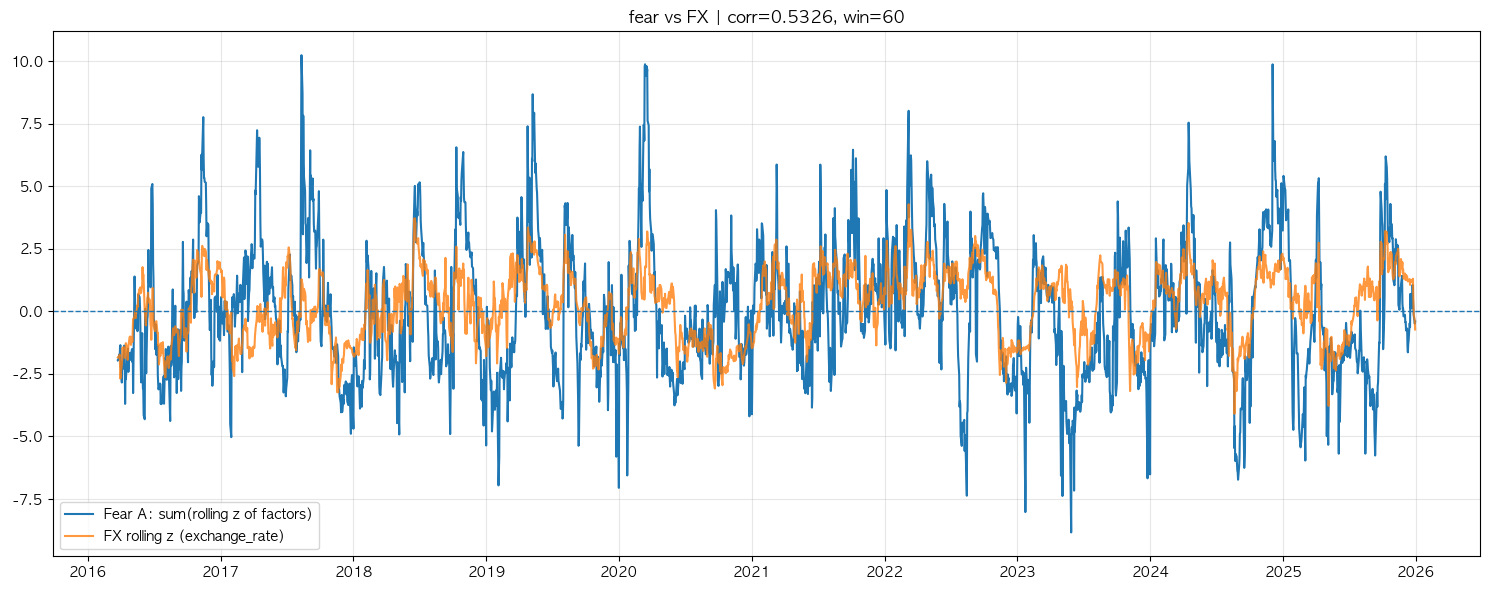

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = merged_df.copy()

FACTORS = ["rank_trend_sum", "cds_norm", "RR_norm"]

need = [FX_COL] + FACTORS
miss = [c for c in need if c not in df.columns]
if miss:
    raise ValueError(f"없는 컬럼: {miss}")

tmp = df[need].dropna().copy()

def rolling_z(s, win=60, min_periods=None, eps=1e-12):
    if min_periods is None:
        min_periods = win
    m = s.rolling(win, min_periods=min_periods).mean()
    sd = s.rolling(win, min_periods=min_periods).std(ddof=0)
    return (s - m) / (sd + eps)

Z_WIN =60

for c in FACTORS:
    tmp[f"{c}_zr"] = rolling_z(tmp[c], win=Z_WIN)

tmp["fear_zsum"] = tmp[[f"{c}_zr" for c in FACTORS]].sum(axis=1)

tmp["fear_simple"] = tmp[FACTORS].sum(axis=1)
tmp["fear_B_z"] = rolling_z(tmp["fear_simple"], win=Z_WIN)

tmp["fx_zr"] = rolling_z(np.log(tmp[FX_COL]), win=Z_WIN)

# 분석 구간
x = tmp.dropna(subset=["fear_zsum", "fx_zr"]).copy()

corr = x["fear_zsum"].corr(x["fx_zr"])

plt.figure(figsize=(15, 6))
plt.plot(x.index, x["fear_zsum"], label="Fear A: sum(rolling z of factors)")
plt.plot(x.index, x["fx_zr"], label=f"FX rolling z ({FX_COL})", alpha=0.8)
plt.axhline(0, linestyle="--", linewidth=1)
plt.grid(True, alpha=0.3)
plt.legend()
plt.title(f"fear vs FX | corr={corr:.4f}, win={Z_WIN}")
plt.tight_layout()
plt.show()




[Lead-Lag (fear_simple vs fx_zr)] best(|corr|) lag=+0, corr=+0.2733  → 동행(0 lag)
    (max corr) lag=+0, corr=+0.2733


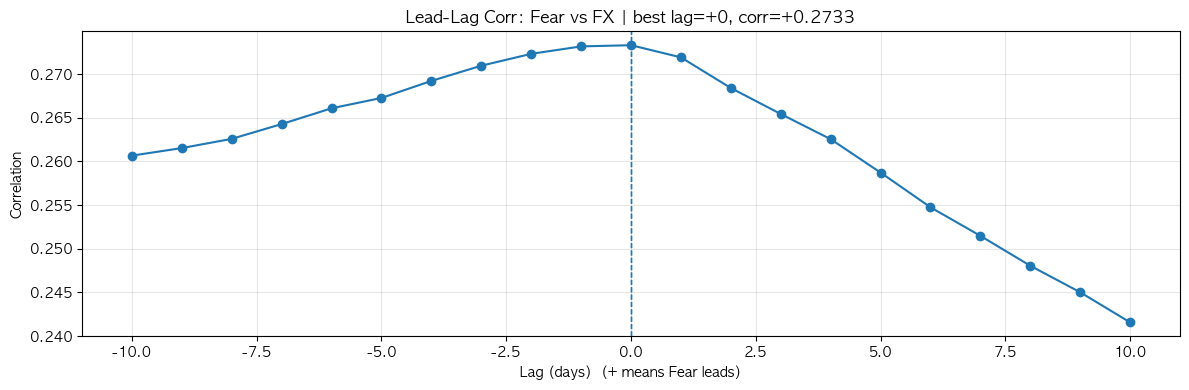

In [73]:
def summarize_best_lag(lc: pd.Series, name=""):
    # lc index: lag, value: corr
    best_lag = lc.idxmax()
    best_corr = lc.loc[best_lag]

    best_lag_pos = lc.idxmax()
    best_corr_pos = lc.loc[best_lag_pos]
    best_lag_neg = lc.idxmin()
    best_corr_neg = lc.loc[best_lag_neg]

    lead_text = "Fear가 선행" if best_lag > 0 else ("FX가 선행" if best_lag < 0 else "동행(0 lag)")
    print(f"\n[{name}] best(|corr|) lag={best_lag:+d}, corr={best_corr:+.4f}  → {lead_text}")
    print(f"    (max corr) lag={best_lag_pos:+d}, corr={best_corr_pos:+.4f}")

    return best_lag, best_corr

def lag_correlation(a: pd.Series, b: pd.Series, max_lag=20):
    # lag>0: a가 선행 (a(t) vs b(t+lag))
    out = {}
    for lag in range(-max_lag, max_lag + 1):
        out[lag] = a.corr(b.shift(-lag))
    return pd.Series(out)
MAX_LAG = 10
lc_A = lag_correlation(tmp["fear_simple"], tmp[FX_COL], max_lag=MAX_LAG)

best_lag, best_corr = summarize_best_lag(lc_A, name="Lead-Lag (fear_simple vs fx_zr)")

# 그래프에도 best lag 표시
plt.figure(figsize=(12, 4))
plt.plot(lc_A.index, lc_A.values, marker="o")
plt.axvline(0, linestyle="--", linewidth=1)
plt.axvline(best_lag, linestyle="--", linewidth=1)
plt.title(f"Lead-Lag Corr: Fear vs FX | best lag={best_lag:+d}, corr={best_corr:+.4f}")
plt.xlabel("Lag (days)  (+ means Fear leads)")
plt.ylabel("Correlation")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
